# Assignment


## import

In [68]:
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
import json
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import zscore
import matplotlib.pyplot as plt

## connect to pgadmin

In [69]:
credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        try:
            db = create_engine('postgresql+psycopg2://'+db_user+':'+db_pw+'@'+host+'/'+default_db, echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn
db, conn = pgconnect(credentials)

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(sqlcmd, args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

Connected successfully.


# Task 1
## show data and clean data
### 1.Neighbourhoods

In [70]:
Neighbourhoods = pd.read_csv('Neighbourhoods.csv', thousands=",")
Neighbourhoods

,Unnamed: 0,area_id,area_name,land_area,population,number_of_dwellings,number_of_businesses,median_annual_household_income,avg_monthly_rent,0-4,5-9,10-14,15-19
0,0,102011028,Avoca Beach - Copacabana,643.8000,7590.0,2325,738.0,46996.0,1906.0,467,583,604,560
1,1,102011029,Box Head - MacMasters Beach,3208.6000,10986.0,3847,907.0,42621.0,1682.0,586,696,661,692
2,2,102011030,Calga - Kulnura,76795.1000,4841.0,1575,1102.0,42105.0,1182.0,220,254,304,320
3,3,102011031,Erina - Green Point,3379.3000,14237.0,4450,1666.0,43481.0,1595.0,695,778,916,838
4,4,102011032,Gosford - Springfield,1691.2000,19385.0,6373,2126.0,45972.0,1382.0,1200,1079,963,977
...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,317,106011109,Cessnock Region,1570.4341,7931.0,3281,673.0,73164.0,1080.0,432,590,577,527
318,318,106011113,Singleton Region,4067.2349,4919.0,2055,698.0,87984.0,1000.0,310,394,353,323
319,319,111021218,Morisset - Cooranbong,330.5208,14959.0,6298,1154.0,58084.0,1260.0,813,855,828,962
320,320,114021285,Hill Top - Colo Vale,174.3752,6025.0,2249,400.0,81120.0,1512.0,443,500,470,451


In [71]:
NC = Neighbourhoods.copy()
NC = NC.drop(columns = 'Unnamed: 0') #remove useless column
NC['young_people'] = NC['0-4'] + NC['5-9']+ NC['10-14'] + NC['15-19'] #create yong people column
#drop useless column
NC = NC.drop(columns = {'number_of_dwellings', '0-4', '5-9', '10-14', '15-19', 'number_of_businesses', 'land_area'})

NC


,area_id,area_name,population,median_annual_household_income,avg_monthly_rent,young_people
0,102011028,Avoca Beach - Copacabana,7590.0,46996.0,1906.0,2214
1,102011029,Box Head - MacMasters Beach,10986.0,42621.0,1682.0,2635
2,102011030,Calga - Kulnura,4841.0,42105.0,1182.0,1098
3,102011031,Erina - Green Point,14237.0,43481.0,1595.0,3227
4,102011032,Gosford - Springfield,19385.0,45972.0,1382.0,4219
...,...,...,...,...,...,...
317,106011109,Cessnock Region,7931.0,73164.0,1080.0,2126
318,106011113,Singleton Region,4919.0,87984.0,1000.0,1380
319,111021218,Morisset - Cooranbong,14959.0,58084.0,1260.0,3458
320,114021285,Hill Top - Colo Vale,6025.0,81120.0,1512.0,1864


### 2. businessstats

In [72]:
BusinessStats = pd.read_csv('BusinessStats.csv')
#drop the useless columns

BusinessStats

,area_id,area_name,number_of_businesses,accommodation_and_food_services,retail_trade,agriculture_forestry_and_fishing,health_care_and_social_assistance,public_administration_and_safety,transport_postal_and_warehousing
0,101021007,Braidwood,629,26,27,280,11,0,35
1,101021008,Karabar,326,7,10,8,11,0,43
2,101021009,Queanbeyan,724,52,47,11,56,3,77
3,101021010,Queanbeyan - East,580,16,23,4,12,0,57
4,101021011,Queanbeyan Region,1642,39,63,292,34,7,81
...,...,...,...,...,...,...,...,...,...
2296,901011001,Christmas Island,0,0,0,0,0,0,0
2297,901021002,Cocos (Keeling) Islands,7,3,0,0,0,0,0
2298,901031003,Jervis Bay,6,0,3,0,0,0,0
2299,901041004,Norfolk Island,0,0,0,0,0,0,0


In [73]:
BusinessStats = BusinessStats.drop(columns = {'number_of_businesses', 'agriculture_forestry_and_fishing', 'transport_postal_and_warehousing'})
BusinessStats

,area_id,area_name,accommodation_and_food_services,retail_trade,health_care_and_social_assistance,public_administration_and_safety
0,101021007,Braidwood,26,27,11,0
1,101021008,Karabar,7,10,11,0
2,101021009,Queanbeyan,52,47,56,3
3,101021010,Queanbeyan - East,16,23,12,0
4,101021011,Queanbeyan Region,39,63,34,7
...,...,...,...,...,...,...
2296,901011001,Christmas Island,0,0,0,0
2297,901021002,Cocos (Keeling) Islands,3,0,0,0
2298,901031003,Jervis Bay,0,3,0,0
2299,901041004,Norfolk Island,0,0,0,0


### 3. break and enter

In [74]:
break_and_enter = gpd.read_file("break_and_enter/BreakEnterDwelling_JanToDec2021.shp")

break_and_enter

,OBJECTID,Contour,Density,ORIG_FID,Shape_Leng,Shape_Area,geometry
0,1,8.0,Low Density,1,0.012138,0.000006,"POLYGON ((149.91078 -37.06636, 149.91080 -37.0..."
1,2,8.0,Low Density,1,0.019106,0.000015,"POLYGON ((149.90601 -37.05837, 149.90602 -37.0..."
2,3,8.0,Low Density,1,0.006068,0.000002,"POLYGON ((148.94250 -37.04209, 148.94253 -37.0..."
3,4,8.0,Low Density,1,0.011006,0.000006,"POLYGON ((149.19583 -36.91833, 149.19584 -36.9..."
4,5,8.0,Low Density,1,0.008073,0.000003,"POLYGON ((149.84836 -36.68459, 149.84838 -36.6..."
...,...,...,...,...,...,...,...
2589,2590,10.0,High Density,3,0.015358,0.000011,"POLYGON ((153.27961 -28.55388, 153.27964 -28.5..."
2590,2591,10.0,High Density,3,0.028327,0.000029,"POLYGON ((150.35939 -28.60530, 150.35941 -28.6..."
2591,2592,10.0,High Density,3,0.006654,0.000002,"POLYGON ((153.56825 -28.38307, 153.56828 -28.3..."
2592,2593,10.0,High Density,3,0.047098,0.000044,"POLYGON ((153.53917 -28.18858, 153.53920 -28.1..."


In [75]:
srid = 4283 #GDA94
#change Polygon to MultiPolygon
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)
be_copy = break_and_enter.copy()
be_copy['geom'] = be_copy['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
be_copy = be_copy.drop(columns="geometry")  # deleting the old column
#Make the column names all lowercase
be_copy.columns = be_copy.columns.map(lambda x : x.lower())
be_copy = be_copy.drop(columns = {'contour', 'orig_fid', 'shape_leng'})
be_copy

,objectid,density,shape_area,geom
0,1,Low Density,0.000006,MULTIPOLYGON (((149.9107801470001 -37.06636313...
1,2,Low Density,0.000015,MULTIPOLYGON (((149.9060088220001 -37.05836717...
2,3,Low Density,0.000002,MULTIPOLYGON (((148.9424993900001 -37.04208530...
3,4,Low Density,0.000006,MULTIPOLYGON (((149.1958326340001 -36.91833255...
4,5,Low Density,0.000003,MULTIPOLYGON (((149.8483600650001 -36.68458912...
...,...,...,...,...
2589,2590,High Density,0.000011,MULTIPOLYGON (((153.2796105350001 -28.55387845...
2590,2591,High Density,0.000029,MULTIPOLYGON (((150.3593920080001 -28.60530123...
2591,2592,High Density,0.000002,MULTIPOLYGON (((153.568248161 -28.383068159999...
2592,2593,High Density,0.000044,MULTIPOLYGON (((153.5391676050001 -28.18857974...


### 4.SA2

In [76]:
SA2 = gpd.read_file("SA2_2016_AUST/SA2_2016_AUST.shp")
SA2

,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,GCC_CODE16,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16,geometry
0,101021007,11007,Braidwood,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3418.3525,"POLYGON ((149.58423 -35.44427, 149.58444 -35.4..."
1,101021008,11008,Karabar,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,6.9825,"POLYGON ((149.21898 -35.36739, 149.21799 -35.3..."
2,101021009,11009,Queanbeyan,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,4.7634,"POLYGON ((149.21325 -35.34325, 149.21619 -35.3..."
3,101021010,11010,Queanbeyan - East,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,13.0034,"POLYGON ((149.24033 -35.34782, 149.24023 -35.3..."
4,101021011,11011,Queanbeyan Region,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3054.4099,"POLYGON ((149.23580 -35.38738, 149.23771 -35.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2305,901021002,91002,Cocos (Keeling) Islands,90102,Cocos (Keeling) Islands,901,Other Territories,9OTER,Other Territories,9,Other Territories,13.7163,"MULTIPOLYGON (((96.83047 -12.17636, 96.83045 -..."
2306,901031003,91003,Jervis Bay,90103,Jervis Bay,901,Other Territories,9OTER,Other Territories,9,Other Territories,67.8134,"MULTIPOLYGON (((150.69566 -35.18297, 150.69555..."
2307,901041004,91004,Norfolk Island,90104,Norfolk Island,901,Other Territories,9OTER,Other Territories,9,Other Territories,38.6509,"MULTIPOLYGON (((167.99472 -29.04534, 167.99432..."
2308,997979799,99799,Migratory - Offshore - Shipping (OT),99797,Migratory - Offshore - Shipping (OT),997,Migratory - Offshore - Shipping (OT),99799,Migratory - Offshore - Shipping (OT),9,Other Territories,0.0000,None


In [77]:
SA2.GCC_NAME16.unique()

array(['Rest of NSW', 'Greater Sydney',
       'Migratory - Offshore - Shipping (NSW)', 'No usual address (NSW)',
       'Rest of Vic.', 'Greater Melbourne',
       'Migratory - Offshore - Shipping (Vic.)',
       'No usual address (Vic.)', 'Greater Brisbane', 'Rest of Qld',
       'Migratory - Offshore - Shipping (Qld)', 'No usual address (Qld)',
       'Greater Adelaide', 'Rest of SA',
       'Migratory - Offshore - Shipping (SA)', 'No usual address (SA)',
       'Rest of WA', 'Greater Perth',
       'Migratory - Offshore - Shipping (WA)', 'No usual address (WA)',
       'Greater Hobart', 'Rest of Tas.',
       'Migratory - Offshore - Shipping (Tas.)',
       'No usual address (Tas.)', 'Greater Darwin', 'Rest of NT',
       'Migratory - Offshore - Shipping (NT)', 'No usual address (NT)',
       'Australian Capital Territory',
       'Migratory - Offshore - Shipping (ACT)', 'No usual address (ACT)',
       'Other Territories', 'Migratory - Offshore - Shipping (OT)',
       'No usual a

In [78]:
SA2_copy = SA2.copy()
SA2_copy = SA2_copy[SA2_copy['GCC_NAME16'] == 'Greater Sydney']#choose the data in greater Sydney
SA2_copy['geom'] = SA2_copy['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  
SA2_copy = SA2_copy.drop(columns="geometry")  # deleting the old column
SA2_copy.columns = SA2_copy.columns.map(lambda x : x.lower())#rename
SA2_copy

,sa2_main16,sa2_5dig16,sa2_name16,sa3_code16,sa3_name16,sa4_code16,sa4_name16,gcc_code16,gcc_name16,ste_code16,ste_name16,areasqkm16,geom
27,102011028,11028,Avoca Beach - Copacabana,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,6.4376,MULTIPOLYGON (((151.4137275700001 -33.46559324...
28,102011029,11029,Box Head - MacMasters Beach,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,32.0860,MULTIPOLYGON (((151.3539836770001 -33.49854010...
29,102011030,11030,Calga - Kulnura,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,767.9512,MULTIPOLYGON (((151.204595054 -33.532982995999...
30,102011031,11031,Erina - Green Point,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,33.7934,MULTIPOLYGON (((151.3679483220001 -33.43822416...
31,102011032,11032,Gosford - Springfield,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,16.9124,MULTIPOLYGON (((151.310060818 -33.426989095999...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,128021537,11537,Royal National Park,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,139.3336,MULTIPOLYGON (((151.071650994 -34.057945007999...
572,128021538,11538,Sutherland - Kirrawee,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,7.7547,MULTIPOLYGON (((151.05049439 -34.0200584319999...
573,128021607,11607,Engadine,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,8.9538,MULTIPOLYGON (((150.9956780320001 -34.05362100...
574,128021608,11608,Loftus - Yarrawarrah,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,3.8436,MULTIPOLYGON (((151.0395427830001 -34.04175791...


### 5.school catchment

In [79]:
primary = gpd.read_file("school_catchments/catchments_primary.shp")
secondary = gpd.read_file("school_catchments/catchments_secondary.shp")
future = gpd.read_file("school_catchments/catchments_future.shp")
primary

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry
0,2838,PRIMARY,Parklea PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((150.93564 -33.71612, 150.93715 -33.7..."
1,3943,PRIMARY,Gordon WPS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.14085 -33.74463, 151.14113 -33.7..."
2,2404,PRIMARY,Lindfield EPS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.18336 -33.74748, 151.18443 -33.7..."
3,4393,PRIMARY,Carlingford WPS,20220223,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.04518 -33.77303, 151.04526 -33.7..."
4,4615,PRIMARY,Caddies Ck PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((150.92567 -33.72960, 150.92602 -33.7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1661,4383,PRIMARY,E A Southee PS,20200315,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((147.94621 -34.55863, 147.95292 -34.5..."
1662,3275,PRIMARY,Tumbarumba PS,20200507,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((148.12885 -35.60082, 148.23155 -35.6..."
1663,2239,PRIMARY,Jindera PS,20200507,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((146.86148 -35.87511, 146.87402 -35.8..."
1664,3594,PRIMARY,Louth PS,20200604,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((145.18403 -29.65805, 145.18434 -29.6..."


In [80]:
secondary.shape

(435, 19)

In [81]:
future.shape

(44, 18)

In [82]:
primary_copy = primary.copy()
secondary_copy = secondary.copy()
future_copy = future.copy()

#primary
primary_copy['geom'] = primary_copy['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid)) #change Polygon to MultiPolygon
primary_copy = primary_copy.drop(columns="geometry") # deleting the old column
primary_copy.columns = primary_copy.columns.map(lambda x : x.lower())#lowercase
#drop useless columns
primary_copy = primary_copy.drop(columns = {'kindergart', 'year1', 'year2', 'year3', 'year4', 'year5', 'year6', 'year7', 'year8', 'year9', 'year10', 'year11', 'year12', 'priority', 'add_date'})
#secondary
secondary_copy['geom'] = secondary_copy['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  #change Polygon to MultiPolygon
secondary_copy = secondary_copy.drop(columns="geometry")# deleting the old column
secondary_copy.columns = secondary_copy.columns.map(lambda x : x.lower())#lowercase
#drop useless columns
secondary_copy = secondary_copy.drop(columns = {'kindergart', 'year1', 'year2', 'year3', 'year4', 'year5', 'year6', 'year7', 'year8', 'year9', 'year10', 'year11', 'year12', 'priority', 'add_date'})
#future
future_copy['geom'] = future_copy['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid)) #change Polygon to MultiPolygon
future_copy = future_copy.drop(columns="geometry")# deleting the old column
future_copy.columns = future_copy.columns.map(lambda x : x.lower())#lowercase
#drop useless columns
future_copy = future_copy.drop(columns = {'kindergart', 'year1', 'year2', 'year3', 'year4', 'year5', 'year6', 'year7', 'year8', 'year9', 'year10', 'year11', 'year12', 'add_date'})

school = primary_copy.append(secondary_copy.append(future_copy))#connect 3 tables to 1 table
school = school.drop_duplicates(subset = ['use_desc'])#drop the rows with repeat names
school

,use_id,catch_type,use_desc,geom
0,2838,PRIMARY,Parklea PS,MULTIPOLYGON (((150.93563850416 -33.7161211047...
1,3943,PRIMARY,Gordon WPS,MULTIPOLYGON (((151.140850430121 -33.744626792...
2,2404,PRIMARY,Lindfield EPS,MULTIPOLYGON (((151.1833640465581 -33.74748398...
3,4393,PRIMARY,Carlingford WPS,MULTIPOLYGON (((151.0451821055135 -33.77303212...
4,4615,PRIMARY,Caddies Ck PS,MULTIPOLYGON (((150.9256732797658 -33.72960300...
...,...,...,...,...
2,4683,PRIMARY,Murrumbateman PS,MULTIPOLYGON (((149.1055691127289 -34.89523076...
30,4678,PRIMARY,Epping South PS,MULTIPOLYGON (((151.076509306985 -33.776860628...
39,4680,PRIMARY,Googong PS,MULTIPOLYGON (((149.266534585277 -35.498376844...
41,8922,HIGH_COED,Jerrabomberra HS,MULTIPOLYGON (((149.1980792584528 -35.38147320...


### 6. Car share bay operator

In [83]:
#https://data.cityofsydney.nsw.gov.au/datasets/cityofsydney::playgrounds/explore
car = gpd.read_file("Car_share_bay_operator.geojson")
car.shape

(794, 6)

In [84]:
car_copy = car.copy()
car_copy['geom'] = car_copy['geometry'].apply(lambda x: WKTElement(x.wkt, srid=srid))#Well-Known Text
car_copy = car_copy.drop(columns="geometry")  # deleting the old column
car_copy.columns = car_copy.columns.map(lambda x : x.lower())

car_copy

,objectid,bay_id,operator,street,suburb,geom
0,1,719,GoGet,Cross Street,Camperdown,POINT (151.180043760805 -33.8833596351986)
1,2,828,Car Next Door,O'Connor Street,Chippendale,POINT (151.200622782023 -33.8860369372971)
2,3,721,Hertz-Flexicar,Victoria Street,Potts Point,POINT (151.222410889426 -33.8741152034228)
3,4,718,GoGet,Wolseley Grove,Zetland,POINT (151.210422591592 -33.9043927073641)
4,5,723,Hertz-Flexicar,Riley Street,Darlinghurst,POINT (151.215372112379 -33.8744196189439)
...,...,...,...,...,...,...
789,790,831,Car Next Door,Liverpool Street,Darlinghurst,POINT (151.218879495278 -33.877869380725)
790,791,832,Car Next Door,Whitehorse Street,Newtown,POINT (151.179280551021 -33.8987448215234)
791,792,185,GoGet,Greens Road,Paddington,POINT (151.220861070384 -33.8836989051182)
792,793,836,Car Next Door,Defries Avenue,Zetland,POINT (151.212154423785 -33.9077238951933)


### 7.playground

In [85]:
#https://data.cityofsydney.nsw.gov.au/datasets/cityofsydney::car-share-bay-operator/explore
playground = gpd.read_file("Playgrounds.geojson")
playground.shape

(151, 4)

In [86]:
p_copy = playground.copy()
p_copy['geom'] = p_copy['geometry'].apply(lambda x: WKTElement(x.wkt, srid=srid))#Well-Known Text
p_copy = p_copy.drop(columns="geometry")  # deleting the old column
p_copy.columns = p_copy.columns.map(lambda x : x.lower())

p_copy

,objectid,name,type,geom
0,1,McKell Playground B,Playground,POINT (151.19672847458 -33.899676710873)
1,2,Minogue Crescent Reserve Playground,Playground,POINT (151.176866581914 -33.8803964500307)
2,3,May Pitt Playground,Playground,POINT (151.181666086631 -33.88390708567)
3,4,Clyne Reserve Playground,Playground,POINT (151.20173393524 -33.8569368835388)
4,5,Shannon Reserve Playground,Playground,POINT (151.214240083107 -33.8857875089495)
...,...,...,...,...
146,4562,Redfern Park Playground C,Playground,POINT (151.206674978278 -33.8951496429259)
147,5762,Frances Newton Playground,Playground,POINT (151.216922453289 -33.8771749885363)
148,6966,Turruwul Park Playground,Playground,POINT (151.204575308304 -33.9185647639693)
149,7366,Waterloo Park & Mount Carmel Fitness Station,Fitness station,POINT (151.204482093686 -33.8996320727047)


## create table

In [92]:
conn.execute("""
DROP TABLE IF EXISTS businessstats;
CREATE TABLE businessstats(
   area_id integer primary key,
   area_name VARCHAR(100),
   accommodation_and_food_services integer,
   retail_trade integer,
   health_care_and_social_assistance integer,
   public_administration_and_safety integer
);""")
BusinessStats.to_sql("businessstats", con=conn, if_exists='append', index=False)
query(conn, "select count(*) from businessstats ")

,count
0,2301


In [93]:
#neighbourhoods
conn.execute("""
DROP TABLE IF EXISTS neighbourhoods;
CREATE TABLE neighbourhoods(
   area_id integer PRIMARY KEY,
   area_name VARCHAR(200),
   population integer,
   median_annual_household_income float,
   avg_monthly_rent float,
   young_people integer,
    foreign key (area_id) references businessstats(area_id)
);""")
NC.to_sql("neighbourhoods", con=conn, if_exists='append', index=False)
query(conn, "select * from neighbourhoods")

,area_id,area_name,population,median_annual_household_income,avg_monthly_rent,young_people
0,102011028,Avoca Beach - Copacabana,7590.0,46996.0,1906.0,2214
1,102011029,Box Head - MacMasters Beach,10986.0,42621.0,1682.0,2635
2,102011030,Calga - Kulnura,4841.0,42105.0,1182.0,1098
3,102011031,Erina - Green Point,14237.0,43481.0,1595.0,3227
4,102011032,Gosford - Springfield,19385.0,45972.0,1382.0,4219
...,...,...,...,...,...,...
317,106011109,Cessnock Region,7931.0,73164.0,1080.0,2126
318,106011113,Singleton Region,4919.0,87984.0,1000.0,1380
319,111021218,Morisset - Cooranbong,14959.0,58084.0,1260.0,3458
320,114021285,Hill Top - Colo Vale,6025.0,81120.0,1512.0,1864


In [94]:
conn.execute("""
DROP TABLE IF EXISTS break_and_enter;
CREATE TABLE break_and_enter(
   OBJECTID integer PRIMARY KEY,
   Density varchar(100),
   shape_area float,
   geom GEOMETRY(MULTIPOLYGON,4283)

);""")
be_copy.to_sql('break_and_enter', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "select count(*) from break_and_enter")

,count
0,2594


In [95]:


conn.execute("""
DROP TABLE IF EXISTS school;

CREATE TABLE school(
   USE_ID integer primary key,
   CATCH_TYPE varchar(100),
   USE_DESC varchar(100),
   geom GEOMETRY(MULTIPOLYGON,4283)

);""")
school.to_sql('school', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "select * from school")

,use_id,catch_type,use_desc,geom
0,2838,PRIMARY,Parklea PS,0106000020BB1000000100000001030000000100000078...
1,3943,PRIMARY,Gordon WPS,0106000020BB100000010000000103000000010000006F...
2,2404,PRIMARY,Lindfield EPS,0106000020BB10000001000000010300000001000000BE...
3,1498,PRIMARY,Brisbania PS,0106000020BB100000010000000103000000010000001F...
4,4393,PRIMARY,Carlingford WPS,0106000020BB1000000100000001030000000100000065...
...,...,...,...,...
2038,8565,HIGH_COED,Hawkesbury HS,0106000020BB1000000100000001030000000100000005...
2039,8146,HIGH_COED,Parkes HS,0106000020BB10000001000000010300000001000000C6...
2040,8213,HIGH_BOYS,Birrong BHS,0106000020BB1000000100000001030000000100000040...
2041,8857,HIGH_GIRLS,GRC Penshurst Girls,0106000020BB10000001000000010300000001000000A1...


In [96]:
conn.execute("""
DROP TABLE IF EXISTS sa2;
CREATE TABLE sa2(
   sa2_main16 integer PRIMARY KEY,
   sa2_5dig16 integer,
   sa2_name16 varchar(100),
   sa3_code16 integer,
   sa3_name16 varchar(100),
   sa4_code16 integer,
   sa4_name16 varchar(100),
   gcc_code16 varchar(100),
   gcc_name16 varchar(100),
   ste_code16 integer,
   ste_name16 varchar(100),
   areasqkm16 float,
  
   geom GEOMETRY(MULTIPOLYGON,4283),
    foreign key (sa2_main16) references neighbourhoods(area_id)

);""")
SA2_copy.to_sql('sa2', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "select count(*) from sa2")

,count
0,312


In [97]:
conn.execute("""
DROP TABLE IF EXISTS car_share;
CREATE TABLE car_share(
   objectid integer PRIMARY KEY,
   bay_id integer,
   operator varchar(100),
   street varchar(100),
   suburb varchar(100),
   geom GEOMETRY(POINT ,4283)
);""")
car_copy.to_sql('car_share', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select * from car_share")

,objectid,bay_id,operator,street,suburb,geom
0,1,719,GoGet,Cross Street,Camperdown,0101000020BB100000341022EBC2E562406AE4B3ED11F1...
1,2,828,Car Next Door,O'Connor Street,Chippendale,0101000020BB100000E2F377806BE66240995E8AA869F1...
2,3,721,Hertz-Flexicar,Victoria Street,Potts Point,0101000020BB1000007C0B71FD1DE7624093D1C901E3EF...
3,4,718,GoGet,Wolseley Grove,Zetland,0101000020BB10000045A728C8BBE66240536FE623C3F3...
4,5,723,Hertz-Flexicar,Riley Street,Darlinghurst,0101000020BB1000006C640E54E4E66240232C69FBECEF...
...,...,...,...,...,...,...
789,790,831,Car Next Door,Liverpool Street,Darlinghurst,0101000020BB1000007D3F920F01E76240D42F1C065EF0...
790,791,832,Car Next Door,Whitehorse Street,Newtown,0101000020BB10000036EE90AABCE5624039F2FF110AF3...
791,792,185,GoGet,Greens Road,Paddington,0101000020BB10000048483C4B11E76240317FB40B1DF1...
792,793,836,Car Next Door,Defries Avenue,Zetland,0101000020BB10000077FB12F8C9E6624094D3ED4B30F4...


In [98]:
conn.execute("""
DROP TABLE IF EXISTS playground;
CREATE TABLE playground(
   objectid integer PRIMARY KEY,
   name varchar(100),
   type varchar(100),
   geom GEOMETRY(POINT ,4283)

);""")
p_copy.to_sql('playground', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select count(*) from playground")

,count
0,151


## index

In [99]:
conn.execute("""
DROP INDEX IF EXISTS sa2_index;
CREATE INDEX sa2_index ON sa2 USING GIST (geom);
""")

In [100]:
conn.execute("""
DROP INDEX IF EXISTS n_pop_index;
CREATE INDEX n_pop_index ON neighbourhoods(population) ;
""")

## connect tables

# Task 2

## score

In [101]:
sql = """
select n.area_id, n.area_name, n.population, n.young_people
from neighbourhoods n join sa2 s on(s.sa2_main16 = n.area_id)
order by n.population
limit 15"""
query(conn, sql)

,area_id,area_name,population,young_people
0,118011342,Centennial Park,3,0
1,125011475,Rookwood Cemetery,3,0
2,124021456,Blue Mountains - South,4,0
3,117011324,Port Botany Industrial,7,0
4,124011451,Blue Mountains - North,13,2
5,117011320,Banksmeadow,21,2
6,125031487,Yennora Industrial,23,0
7,128021537,Royal National Park,28,8
8,125031486,Smithfield Industrial,35,0
9,116031318,Prospect Reservoir,40,8


In [102]:

#To prevent the value of appearing from being too large to affect the image, the score of the area below 500 people is 0, school score of the area below 500 young people is 0
#when population is null, then the area has 0 people
s = """
select n.area_id, n.area_name,n.population,n.young_people,
    n.median_annual_household_income, n.avg_monthly_rent,
    (bu.accommodation_and_food_services/(n.population/1000.0)) as accom,
    (bu.retail_trade/(n.population/1000.0)) as retail,
    (bu.health_care_and_social_assistance/(n.population/1000.0)) as health,
    (count(sc.use_desc)/(n.young_people/1000.0)) as school,
    (sum( be.shape_area)/s.areasqkm16) as crime,
    s.geom
from (sa2 s join neighbourhoods n on (s.sa2_main16 = n.area_id)
    join businessstats bu on (n.area_id = bu.area_id)
    join school sc on (ST_Intersects(s.geom, sc.geom)))
    full outer join break_and_enter be on(ST_intersects(s.geom, be.geom))

where n.population > 500 and n.young_people> 500 
group by n.area_id, bu.accommodation_and_food_services, n.population, 
    bu.retail_trade, bu.health_care_and_social_assistance, n.young_people,s.geom,s.areasqkm16

union

select n.area_id, n.area_name,n.population,n.young_people,n.median_annual_household_income, n.avg_monthly_rent,
0 as accom, 0 as retail, 0 as health, (count(sc.use_desc)/(n.young_people/1000.0)) as school, 0 as crime, s.geom
from (sa2 s join neighbourhoods n on (s.sa2_main16 = n.area_id)
    join businessstats bu on (n.area_id = bu.area_id)
    join school sc on (ST_Intersects(s.geom, sc.geom)))
    full outer join break_and_enter be on(ST_intersects(s.geom, be.geom))
where n.population<500 and n.young_people > 500
group by n.area_id, s.geom

union

select n.area_id, n.area_name,n.population,n.young_people,
    n.median_annual_household_income, n.avg_monthly_rent,
    (bu.accommodation_and_food_services/(n.population/1000.0)) as accom,
    (bu.retail_trade/(n.population/1000.0)) as retail,
    (bu.health_care_and_social_assistance/(n.population/1000.0)) as health,
    0 as school,
    (sum( be.shape_area)/s.areasqkm16) as crime,
    s.geom
from (sa2 s join neighbourhoods n on (s.sa2_main16 = n.area_id)
    join businessstats bu on (n.area_id = bu.area_id)
    join school sc on (ST_Intersects(s.geom, sc.geom)))
    full outer join break_and_enter be on(ST_intersects(s.geom, be.geom))
where n.population > 500 and n.young_people < 500
group by n.area_id, bu.accommodation_and_food_services, n.population, 
    bu.retail_trade, bu.health_care_and_social_assistance,s.geom,s.areasqkm16

union

select n.area_id, n.area_name,n.population,n.young_people,n.median_annual_household_income, n.avg_monthly_rent,
0 as accom, 0 as retail, 0 as health, 0 as school, 0 as crime, s.geom
from (sa2 s join neighbourhoods n on (s.sa2_main16 = n.area_id)
    join businessstats bu on (n.area_id = bu.area_id)
    join school sc on (ST_Intersects(s.geom, sc.geom)))
    full outer join break_and_enter be on(ST_intersects(s.geom, be.geom))
where n.population < 500 and n.young_people < 500
group by n.area_id, s.geom

union

select n.area_id, n.area_name,n.population,n.young_people,n.median_annual_household_income, n.avg_monthly_rent,
0 as accom, 0 as retail, 0 as health, 0 as school, 0 as crime, s.geom
from (sa2 s join neighbourhoods n on (s.sa2_main16 = n.area_id)
    join businessstats bu on (n.area_id = bu.area_id)
    join school sc on (ST_Intersects(s.geom, sc.geom)))

where n.population is null or n.young_people is null
group by n.area_id, s.geom;

 """

query(conn, s)

,area_id,area_name,population,young_people,median_annual_household_income,avg_monthly_rent,accom,retail,health,school,crime,geom
0,102011028,Avoca Beach - Copacabana,7590.0,2214,46996.0,1906.0,4.347826,4.611331,7.905138,2.710027,NaN,0106000020BB100000010000000103000000010000005E...
1,102011029,Box Head - MacMasters Beach,10986.0,2635,42621.0,1682.0,2.093574,4.096122,3.914072,12.144213,0.000008,0106000020BB1000000100000001030000000100000000...
2,102011030,Calga - Kulnura,4841.0,1098,42105.0,1182.0,2.891964,8.882462,2.478827,24.590164,NaN,0106000020BB1000000200000001030000000100000085...
3,102011031,Erina - Green Point,14237.0,3227,43481.0,1595.0,4.776287,10.184730,12.572873,26.340254,0.000013,0106000020BB1000000100000001030000000100000041...
4,102011032,Gosford - Springfield,19385.0,4219,45972.0,1382.0,4.849110,8.614908,12.690224,23.228253,0.000772,0106000020BB100000010000000103000000010000007F...
...,...,...,...,...,...,...,...,...,...,...,...,...
307,128021537,Royal National Park,28.0,8,NaN,1899.0,0.000000,0.000000,0.000000,0.000000,0.000000,0106000020BB1000000100000001030000000100000047...
308,128021538,Sutherland - Kirrawee,21760.0,4894,53378.0,1809.0,3.354779,5.193015,5.836397,15.324888,0.000724,0106000020BB1000000100000001030000000100000089...
309,128021607,Engadine,17424.0,5176,52667.0,1955.0,2.123508,3.960055,4.706152,5.795981,0.000076,0106000020BB100000010000000103000000010000008E...
310,128021608,Loftus - Yarrawarrah,7426.0,2054,51243.0,2163.0,1.211958,2.693240,3.366550,2.921130,NaN,0106000020BB10000001000000010300000001000000A1...


In [103]:
score = pd.read_sql_query(s, conn)
score = score.fillna(0)#change null value to 0

In [104]:
from scipy import stats
accom = stats.zscore(score.accom)
retail = stats.zscore(score.retail)
health = stats.zscore(score.health)
school = stats.zscore(score.school)
crime = stats.zscore(score.crime)

score = score.fillna(0)#change null value to 0
score['Zaccom'] = accom
score['Zretail'] = retail
score['Zhealth'] = health
score['Zschool'] = school
score['Zcrime'] = crime
score['total_score'] = accom + health + retail + school - crime 
score


,area_id,area_name,population,young_people,median_annual_household_income,avg_monthly_rent,accom,retail,health,school,crime,geom,Zaccom,Zretail,Zhealth,Zschool,Zcrime,total_score
0,102011028,Avoca Beach - Copacabana,7590.0,2214,46996.0,1906.0,4.347826,4.611331,7.905138,2.710027,0.000000,0106000020BB100000010000000103000000010000005E...,0.176792,-0.219231,0.384635,-1.025324,-0.497786,-0.185341
1,102011029,Box Head - MacMasters Beach,10986.0,2635,42621.0,1682.0,2.093574,4.096122,3.914072,12.144213,0.000008,0106000020BB1000000100000001030000000100000000...,-0.428525,-0.327254,-0.429997,-0.440769,-0.496698,-1.129848
2,102011030,Calga - Kulnura,4841.0,1098,42105.0,1182.0,2.891964,8.882462,2.478827,24.590164,0.000000,0106000020BB1000000200000001030000000100000085...,-0.214139,0.676293,-0.722951,0.330399,-0.497786,0.567388
3,102011031,Erina - Green Point,14237.0,3227,43481.0,1595.0,4.776287,10.184730,12.572873,26.340254,0.000013,0106000020BB1000000100000001030000000100000041...,0.291843,0.949338,1.337385,0.438837,-0.496093,3.513497
4,102011032,Gosford - Springfield,19385.0,4219,45972.0,1382.0,4.849110,8.614908,12.690224,23.228253,0.000772,0106000020BB100000010000000103000000010000007F...,0.311398,0.620195,1.361338,0.246013,-0.398674,2.937619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,128021537,Royal National Park,28.0,8,0.0,1899.0,0.000000,0.000000,0.000000,0.000000,0.000000,0106000020BB1000000100000001030000000100000047...,-0.990697,-1.186083,-1.228914,-1.193241,-0.497786,-4.101149
308,128021538,Sutherland - Kirrawee,21760.0,4894,53378.0,1809.0,3.354779,5.193015,5.836397,15.324888,0.000724,0106000020BB1000000100000001030000000100000089...,-0.089863,-0.097269,-0.037624,-0.243690,-0.404853,-0.063594
309,128021607,Engadine,17424.0,5176,52667.0,1955.0,2.123508,3.960055,4.706152,5.795981,0.000076,0106000020BB100000010000000103000000010000008E...,-0.420487,-0.355783,-0.268322,-0.834114,-0.487972,-1.390734
310,128021608,Loftus - Yarrawarrah,7426.0,2054,51243.0,2163.0,1.211958,2.693240,3.366550,2.921130,0.000000,0106000020BB10000001000000010300000001000000A1...,-0.665259,-0.621395,-0.541754,-1.012244,-0.497786,-2.342865


In [105]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
score['Sydney liveability score'] = sigmoid(score['total_score'])
score = score.drop(columns = 'total_score')
score.sort_values(by='Sydney liveability score', inplace=True, ascending=False)#order the score descend

In [106]:
score = score[['area_id', 'area_name','median_annual_household_income','avg_monthly_rent','population','young_people','Zaccom', 'Zretail', 'Zhealth', 'Zschool', 'Zcrime', 'Sydney liveability score', 'geom']]
score

,area_id,area_name,median_annual_household_income,avg_monthly_rent,population,young_people,Zaccom,Zretail,Zhealth,Zschool,Zcrime,Sydney liveability score,geom
83,117031337,Sydney - Haymarket - The Rocks,27311.0,2998.0,31010.0,2617,13.600087,10.314945,6.781622,-0.482947,1.162882,1.000000,0106000020BB100000030000000103000000010000000E...
104,119011355,Chullora,41625.0,2280.0,1225.0,246,2.078130,9.596891,0.603946,-1.193241,-0.497786,0.999991,0106000020BB10000001000000010300000001000000E5...
56,116021312,Riverstone - Marsden Park,49900.0,1891.0,21668.0,5214,-0.346283,-0.015235,-0.682550,10.452736,-0.345189,0.999942,0106000020BB10000001000000010300000001000000D2...
172,121041417,North Sydney - Lavender Bay,71668.0,2749.0,11819.0,1576,4.053044,2.166775,3.278553,-0.564192,-0.214477,0.999894,0106000020BB10000001000000010300000001000000CD...
154,121011401,St Leonards - Naremburn,73803.0,2626.0,11400.0,1972,1.694527,1.278446,3.408412,1.571768,0.001849,0.999648,0106000020BB10000001000000010300000001000000AB...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,117011320,Banksmeadow,49680.0,0.0,21.0,2,-0.990697,-1.186083,-1.228914,-1.193241,-0.497786,0.016284,0106000020BB10000001000000010300000001000000FE...
70,117011324,Port Botany Industrial,0.0,0.0,7.0,0,-0.990697,-1.186083,-1.228914,-1.193241,-0.497786,0.016284,0106000020BB10000001000000010300000001000000E3...
71,117011325,Sydney Airport,0.0,0.0,202.0,22,-0.990697,-1.186083,-1.228914,-1.193241,-0.497786,0.016284,0106000020BB10000001000000010300000001000000CB...
229,125011475,Rookwood Cemetery,0.0,0.0,3.0,0,-0.990697,-1.186083,-1.228914,-1.193241,-0.497786,0.016284,0106000020BB1000000100000001030000000100000068...


In [107]:
conn.execute("""
DROP TABLE IF EXISTS score;
CREATE TABLE score(
   area_id integer primary key,
   area_name varchar(100),
   median_annual_household_income float,
   avg_monthly_rent float,
   population integer,
   young_people integer,
   "Zaccom" float,
   "Zretail" float,
   "Zhealth" float,
   "Zschool" float,
   "Zcrime" float,
   "Sydney liveability score" float,
   geom GEOMETRY(MULTIPOLYGON,4283)
    

);""")


score.to_sql("score", con=conn, if_exists='append', index=False)
query(conn, "select * from score")


,area_id,area_name,median_annual_household_income,avg_monthly_rent,population,young_people,Zaccom,Zretail,Zhealth,Zschool,Zcrime,Sydney liveability score,geom
0,117031337,Sydney - Haymarket - The Rocks,27311.0,2998.0,31010,2617,13.600087,10.314945,6.781622,-0.482947,1.162882,1.000000,0106000020BB100000030000000103000000010000000E...
1,119011355,Chullora,41625.0,2280.0,1225,246,2.078130,9.596891,0.603946,-1.193241,-0.497786,0.999991,0106000020BB10000001000000010300000001000000E5...
2,116021312,Riverstone - Marsden Park,49900.0,1891.0,21668,5214,-0.346283,-0.015235,-0.682550,10.452736,-0.345189,0.999942,0106000020BB10000001000000010300000001000000D2...
3,119041378,Kogarah,47168.0,1996.0,12226,2511,0.392986,0.614607,3.161891,0.386021,0.107781,0.988430,0106000020BB10000001000000010300000001000000CD...
4,102021055,Tuggerah - Kangy Angy,44360.0,1699.0,5480,1548,1.116322,1.492170,0.372711,0.808095,-0.483267,0.986246,0106000020BB100000010000000103000000010000006C...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,127011592,Badgerys Creek,46021.0,553.0,62,13,-0.990697,-1.186083,-1.228914,-1.193241,-0.497786,0.016284,0106000020BB1000000100000001030000000100000070...
308,117011320,Banksmeadow,49680.0,0.0,21,2,-0.990697,-1.186083,-1.228914,-1.193241,-0.497786,0.016284,0106000020BB10000001000000010300000001000000FE...
309,117011324,Port Botany Industrial,0.0,0.0,7,0,-0.990697,-1.186083,-1.228914,-1.193241,-0.497786,0.016284,0106000020BB10000001000000010300000001000000E3...
310,117011325,Sydney Airport,0.0,0.0,202,22,-0.990697,-1.186083,-1.228914,-1.193241,-0.497786,0.016284,0106000020BB10000001000000010300000001000000CB...


## Greater Sydney map

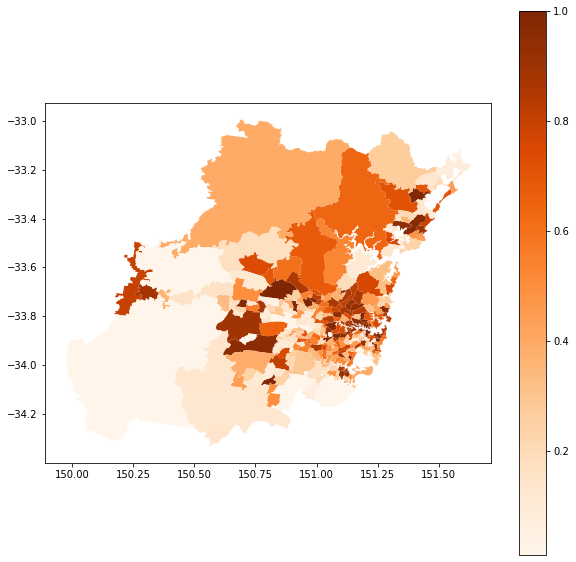

In [108]:
#新图
score_map = gpd.read_postgis("select * from score", conn, geom_col = 'geom')
score_map.plot(cmap = "Oranges", figsize=(10, 10), column = 'Sydney liveability score', legend = True)

In [109]:
conn.execute("""
DROP TABLE IF EXISTS score;""")

In [110]:
score.head()

,area_id,area_name,median_annual_household_income,avg_monthly_rent,population,young_people,Zaccom,Zretail,Zhealth,Zschool,Zcrime,Sydney liveability score,geom
83,117031337,Sydney - Haymarket - The Rocks,27311.0,2998.0,31010.0,2617,13.600087,10.314945,6.781622,-0.482947,1.162882,1.000000,0106000020BB100000030000000103000000010000000E...
104,119011355,Chullora,41625.0,2280.0,1225.0,246,2.078130,9.596891,0.603946,-1.193241,-0.497786,0.999991,0106000020BB10000001000000010300000001000000E5...
56,116021312,Riverstone - Marsden Park,49900.0,1891.0,21668.0,5214,-0.346283,-0.015235,-0.682550,10.452736,-0.345189,0.999942,0106000020BB10000001000000010300000001000000D2...
172,121041417,North Sydney - Lavender Bay,71668.0,2749.0,11819.0,1576,4.053044,2.166775,3.278553,-0.564192,-0.214477,0.999894,0106000020BB10000001000000010300000001000000CD...
154,121011401,St Leonards - Naremburn,73803.0,2626.0,11400.0,1972,1.694527,1.278446,3.408412,1.571768,0.001849,0.999648,0106000020BB10000001000000010300000001000000AB...


## correlation

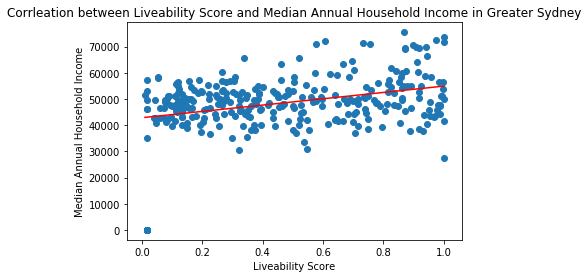

In [111]:
#correlation of median income and score
x = score['Sydney liveability score']
y = score['median_annual_household_income']
income = plt.scatter(x, y) 
income = plt.title('Corrleation between Liveability Score and Median Annual Household Income in Greater Sydney')
income = plt.xlabel('Liveability Score')
income = plt.ylabel('Median Annual Household Income')
#best fit line
income = plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='red')

In [112]:
corr = y.corr(x)
corr

0.3339462636406708

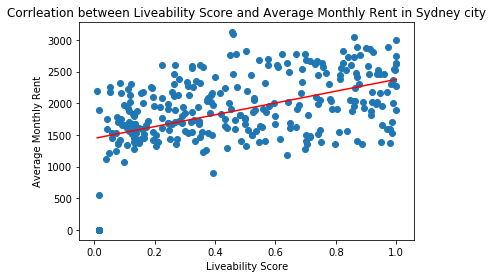

In [113]:
#correlation of average rent and score
x = score['Sydney liveability score']
y = score['avg_monthly_rent']
rent = plt.scatter(x, y) 
rent = plt.title('Corrleation between Liveability Score and Average Monthly Rent in Sydney city')
rent = plt.xlabel('Liveability Score')
rent = plt.ylabel('Average Monthly Rent')
#best fit line
rent = plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='red')

In [114]:
corr = y.corr(x)
corr

0.4854053627413829

# Task 3

## improve score

In [115]:

test = """
select n.area_id, n.area_name,n.population,n.young_people,
    n.median_annual_household_income, n.avg_monthly_rent,
    (bu.accommodation_and_food_services/(n.population/1000.0)) as accom,
    (bu.retail_trade/(n.population/1000.0)) as retail,
    (bu.health_care_and_social_assistance/(n.population/1000.0)) as health,
   (sum( be.shape_area)/s.areasqkm16) as crime,
    (count(distinct c.objectid)/ (n.population / 1000.0)) as car_share, 
    (count(distinct p.objectid)/ (n.population / 1000.0)) as playground,
    s.geom
from sa2 s join neighbourhoods n on (s.sa2_main16 = n.area_id)
    join businessstats bu on (n.area_id = bu.area_id)
    full outer join break_and_enter be on(ST_intersects(s.geom, be.geom))
    join car_share c on (ST_contains(s.geom, c.geom))
    join playground p on (ST_contains(s.geom, p.geom))
where s.sa3_name16 = 'Sydney Inner City'
group by n.area_id, bu.accommodation_and_food_services, n.population, 
    bu.retail_trade, bu.health_care_and_social_assistance, n.young_people,s.geom,s.areasqkm16
"""
query(conn, test)

,area_id,area_name,population,young_people,median_annual_household_income,avg_monthly_rent,accom,retail,health,crime,car_share,playground,geom
0,117031329,Darlinghurst,12414,818,59293.0,2491.0,15.708072,12.083132,22.555180,2.690883,6.686000,0.402771,0106000020BB10000001000000010300000001000000A8...
1,117031330,Erskineville - Alexandria,17822,2252,69680.0,2581.0,7.799349,14.644821,6.284368,1.905738,2.917742,1.514981,0106000020BB100000010000000103000000010000000A...
2,117031331,Glebe - Forest Lodge,21592,2726,56691.0,2162.0,5.603927,5.372360,8.382734,3.533868,2.825120,1.111523,0106000020BB1000000100000001030000000100000008...
3,117031332,Newtown - Camperdown - Darlington,27450,4049,58210.0,2270.0,7.322404,5.974499,13.114754,1.002704,2.331512,0.327869,0106000020BB1000000100000001030000000100000014...
4,117031333,Potts Point - Woolloomooloo,23809,1449,58253.0,2256.0,8.400185,5.880129,6.636146,2.924509,4.032089,0.336007,0106000020BB10000001000000010300000001000000B1...
5,117031334,Pyrmont - Ultimo,24083,2815,47393.0,2575.0,9.591828,8.968982,6.934352,2.474213,3.446414,0.332185,0106000020BB1000000100000001030000000100000027...
6,117031335,Redfern - Chippendale,25538,2532,51347.0,2193.0,5.599499,5.207925,5.051296,4.182747,3.445845,0.704832,0106000020BB100000010000000103000000010000003F...
7,117031336,Surry Hills,18064,1260,58396.0,2342.0,15.223649,13.396811,11.403897,9.192779,6.698406,0.996457,0106000020BB10000001000000010300000001000000A2...
8,117031337,Sydney - Haymarket - The Rocks,31010,2617,27311.0,2998.0,54.337311,54.853273,39.245405,0.425766,1.515640,0.225734,0106000020BB100000030000000103000000010000000E...
9,117031338,Waterloo - Beaconsfield,37929,5215,57055.0,2302.0,6.090327,8.726832,4.060218,2.970187,2.135569,0.606396,0106000020BB10000001000000010300000001000000F7...


In [116]:
task3 = pd.read_sql_query(test, conn)


In [117]:
t_copy = task3.copy()
t_copy

,area_id,area_name,population,young_people,median_annual_household_income,avg_monthly_rent,accom,retail,health,crime,car_share,playground,geom
0,117031329,Darlinghurst,12414,818,59293.0,2491.0,15.708072,12.083132,22.555180,2.690883,6.686000,0.402771,0106000020BB10000001000000010300000001000000A8...
1,117031330,Erskineville - Alexandria,17822,2252,69680.0,2581.0,7.799349,14.644821,6.284368,1.905738,2.917742,1.514981,0106000020BB100000010000000103000000010000000A...
2,117031331,Glebe - Forest Lodge,21592,2726,56691.0,2162.0,5.603927,5.372360,8.382734,3.533868,2.825120,1.111523,0106000020BB1000000100000001030000000100000008...
3,117031332,Newtown - Camperdown - Darlington,27450,4049,58210.0,2270.0,7.322404,5.974499,13.114754,1.002704,2.331512,0.327869,0106000020BB1000000100000001030000000100000014...
4,117031333,Potts Point - Woolloomooloo,23809,1449,58253.0,2256.0,8.400185,5.880129,6.636146,2.924509,4.032089,0.336007,0106000020BB10000001000000010300000001000000B1...
5,117031334,Pyrmont - Ultimo,24083,2815,47393.0,2575.0,9.591828,8.968982,6.934352,2.474213,3.446414,0.332185,0106000020BB1000000100000001030000000100000027...
6,117031335,Redfern - Chippendale,25538,2532,51347.0,2193.0,5.599499,5.207925,5.051296,4.182747,3.445845,0.704832,0106000020BB100000010000000103000000010000003F...
7,117031336,Surry Hills,18064,1260,58396.0,2342.0,15.223649,13.396811,11.403897,9.192779,6.698406,0.996457,0106000020BB10000001000000010300000001000000A2...
8,117031337,Sydney - Haymarket - The Rocks,31010,2617,27311.0,2998.0,54.337311,54.853273,39.245405,0.425766,1.515640,0.225734,0106000020BB100000030000000103000000010000000E...
9,117031338,Waterloo - Beaconsfield,37929,5215,57055.0,2302.0,6.090327,8.726832,4.060218,2.970187,2.135569,0.606396,0106000020BB10000001000000010300000001000000F7...


In [118]:
t_copy = t_copy.fillna(0)
a = stats.zscore(t_copy.accom)
r = stats.zscore(t_copy.retail)
h = stats.zscore(t_copy.health)
c = stats.zscore(t_copy.crime)
car = stats.zscore(t_copy.car_share)
play = stats.zscore(t_copy.playground)

t_copy['Zaccom'] = a
t_copy['Zretail'] = r
t_copy['Zhealth'] = h
t_copy['Zcrime'] = c
t_copy['Zcar_share'] = car
t_copy['Zplayground'] = play
t_copy['Sydney liveability score'] = sigmoid(t_copy['Zaccom'] + t_copy['Zretail'] + t_copy['Zhealth'] - t_copy['Zcrime'] + t_copy['Zcar_share'] + t_copy['Zplayground'])
t_copy = t_copy[['area_id', 'area_name', 'Zaccom', 'Zretail', 'Zhealth', 'Zcrime', 'Zcar_share', 'Zplayground', 'Sydney liveability score', 'population', 'young_people', 'median_annual_household_income', 'avg_monthly_rent', 'geom']]
t_copy

,area_id,area_name,Zaccom,Zretail,Zhealth,Zcrime,Zcar_share,Zplayground,Sydney liveability score,population,young_people,median_annual_household_income,avg_monthly_rent,geom
0,117031329,Darlinghurst,0.152611,-0.100799,0.987029,-0.192610,1.825265,-0.626857,0.919076,12414,818,59293.0,2491.0,0106000020BB10000001000000010300000001000000A8...
1,117031330,Erskineville - Alexandria,-0.411278,0.080057,-0.589259,-0.536732,-0.406015,2.127724,0.792155,17822,2252,69680.0,2581.0,0106000020BB100000010000000103000000010000000A...
2,117031331,Glebe - Forest Lodge,-0.567810,-0.574583,-0.385973,0.176863,-0.460859,1.128489,0.261613,21592,2726,56691.0,2162.0,0106000020BB1000000100000001030000000100000008...
3,117031332,Newtown - Camperdown - Darlington,-0.445284,-0.532072,0.072457,-0.932524,-0.753137,-0.812365,0.176844,27450,4049,58210.0,2270.0,0106000020BB1000000100000001030000000100000014...
4,117031333,Potts Point - Woolloomooloo,-0.368438,-0.538735,-0.555179,-0.090214,0.253817,-0.792209,0.128921,23809,1449,58253.0,2256.0,0106000020BB10000001000000010300000001000000B1...
5,117031334,Pyrmont - Ultimo,-0.283475,-0.320660,-0.526289,-0.287574,-0.092975,-0.801677,0.149631,24083,2815,47393.0,2575.0,0106000020BB1000000100000001030000000100000027...
6,117031335,Redfern - Chippendale,-0.568126,-0.586193,-0.708716,0.461261,-0.093312,0.121249,0.091425,25538,2532,51347.0,2193.0,0106000020BB100000010000000103000000010000003F...
7,117031336,Surry Hills,0.118072,-0.008053,-0.093288,2.657115,1.832611,0.843509,0.508933,18064,1260,58396.0,2342.0,0106000020BB10000001000000010300000001000000A2...
8,117031337,Sydney - Haymarket - The Rocks,2.906860,2.918794,2.603948,-1.185391,-1.236235,-1.065321,0.999334,31010,2617,27311.0,2998.0,0106000020BB100000030000000103000000010000000E...
9,117031338,Waterloo - Beaconsfield,-0.533130,-0.337756,-0.804730,-0.070194,-0.869160,-0.122544,0.069324,37929,5215,57055.0,2302.0,0106000020BB10000001000000010300000001000000F7...


In [119]:
conn.execute("""
DROP TABLE IF EXISTS task3_score;
CREATE TABLE task3_score(
   area_id integer primary key,
   area_name varchar(100),  
   "Zaccom" float,
   "Zretail" float,
   "Zhealth" float,
   "Zcrime" float,
   "Zcar_share" float,
   "Zplayground" float,
   "Sydney liveability score" float,
   population integer,
   young_people integer,
   median_annual_household_income float,
   avg_monthly_rent float,
   geom GEOMETRY(MULTIPOLYGON,4283)
    

);""")


t_copy.to_sql("task3_score", con=conn, if_exists='append', index=False)
query(conn, "select * from task3_score")

,area_id,area_name,Zaccom,Zretail,Zhealth,Zcrime,Zcar_share,Zplayground,Sydney liveability score,population,young_people,median_annual_household_income,avg_monthly_rent,geom
0,117031329,Darlinghurst,0.152611,-0.100799,0.987029,-0.192610,1.825265,-0.626857,0.919076,12414,818,59293.0,2491.0,0106000020BB10000001000000010300000001000000A8...
1,117031330,Erskineville - Alexandria,-0.411278,0.080057,-0.589259,-0.536732,-0.406015,2.127724,0.792155,17822,2252,69680.0,2581.0,0106000020BB100000010000000103000000010000000A...
2,117031337,Sydney - Haymarket - The Rocks,2.906860,2.918794,2.603948,-1.185391,-1.236235,-1.065321,0.999334,31010,2617,27311.0,2998.0,0106000020BB100000030000000103000000010000000E...
3,117031331,Glebe - Forest Lodge,-0.567810,-0.574583,-0.385973,0.176863,-0.460859,1.128489,0.261613,21592,2726,56691.0,2162.0,0106000020BB1000000100000001030000000100000008...
4,117031332,Newtown - Camperdown - Darlington,-0.445284,-0.532072,0.072457,-0.932524,-0.753137,-0.812365,0.176844,27450,4049,58210.0,2270.0,0106000020BB1000000100000001030000000100000014...
5,117031333,Potts Point - Woolloomooloo,-0.368438,-0.538735,-0.555179,-0.090214,0.253817,-0.792209,0.128921,23809,1449,58253.0,2256.0,0106000020BB10000001000000010300000001000000B1...
6,117031334,Pyrmont - Ultimo,-0.283475,-0.320660,-0.526289,-0.287574,-0.092975,-0.801677,0.149631,24083,2815,47393.0,2575.0,0106000020BB1000000100000001030000000100000027...
7,117031335,Redfern - Chippendale,-0.568126,-0.586193,-0.708716,0.461261,-0.093312,0.121249,0.091425,25538,2532,51347.0,2193.0,0106000020BB100000010000000103000000010000003F...
8,117031336,Surry Hills,0.118072,-0.008053,-0.093288,2.657115,1.832611,0.843509,0.508933,18064,1260,58396.0,2342.0,0106000020BB10000001000000010300000001000000A2...
9,117031338,Waterloo - Beaconsfield,-0.533130,-0.337756,-0.804730,-0.070194,-0.869160,-0.122544,0.069324,37929,5215,57055.0,2302.0,0106000020BB10000001000000010300000001000000F7...


## sydney city map

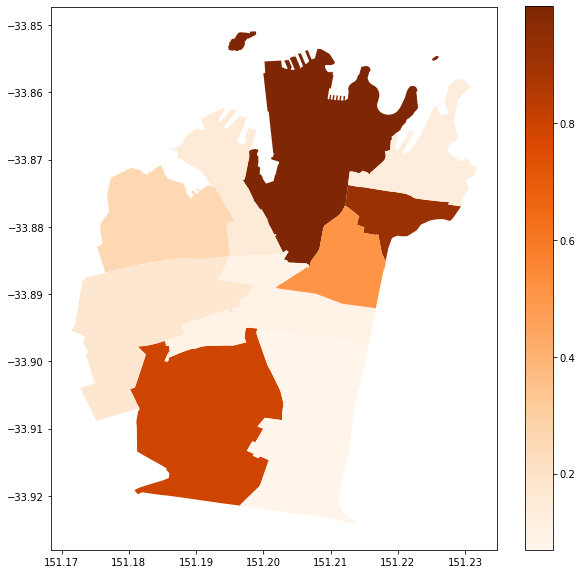

In [120]:
score_map = gpd.read_postgis("select * from task3_score", conn, geom_col = 'geom')
score_map.plot(cmap = "Oranges", figsize=(10, 10), column = 'Sydney liveability score', legend = True)

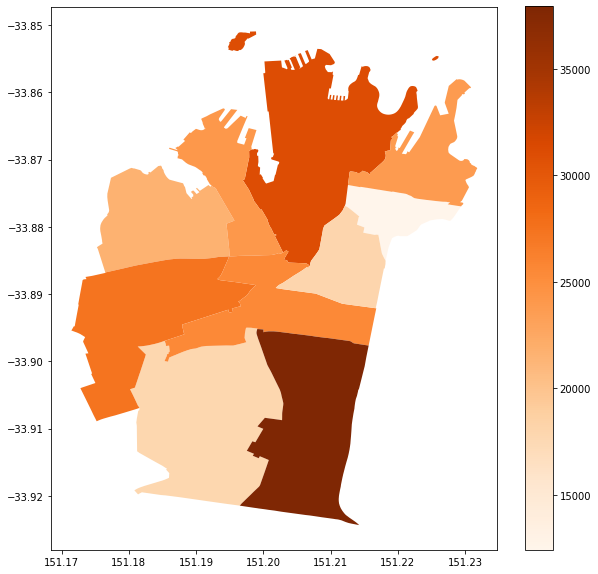

In [121]:
#population distribution
score_map = gpd.read_postgis("select * from task3_score", conn, geom_col = 'geom')
score_map.plot(cmap = "Oranges", figsize=(10, 10), column = 'population', legend = True)

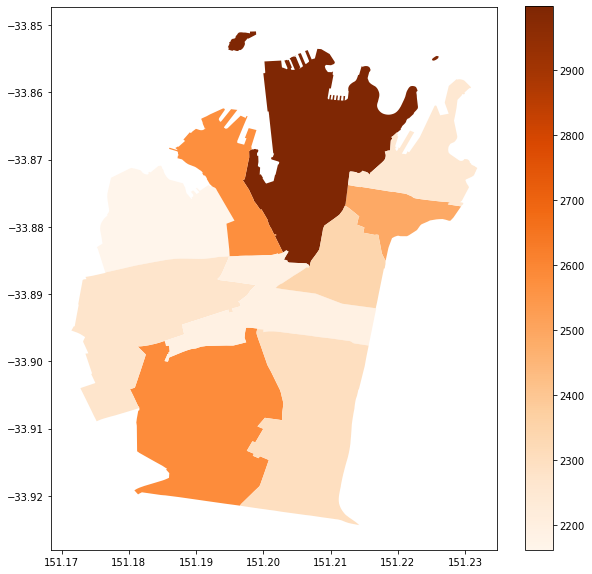

In [122]:
#rent
score_map = gpd.read_postgis("select * from task3_score", conn, geom_col = 'geom')
score_map.plot(cmap = "Oranges", figsize=(10, 10), column = 'avg_monthly_rent', legend = True)

In [123]:
conn.execute("""DROP TABLE IF EXISTS task3_score;""")

In [124]:
t_copy.sort_values(by=['Sydney liveability score'], ascending=False)

,area_id,area_name,Zaccom,Zretail,Zhealth,Zcrime,Zcar_share,Zplayground,Sydney liveability score,population,young_people,median_annual_household_income,avg_monthly_rent,geom
8,117031337,Sydney - Haymarket - The Rocks,2.906860,2.918794,2.603948,-1.185391,-1.236235,-1.065321,0.999334,31010,2617,27311.0,2998.0,0106000020BB100000030000000103000000010000000E...
0,117031329,Darlinghurst,0.152611,-0.100799,0.987029,-0.192610,1.825265,-0.626857,0.919076,12414,818,59293.0,2491.0,0106000020BB10000001000000010300000001000000A8...
1,117031330,Erskineville - Alexandria,-0.411278,0.080057,-0.589259,-0.536732,-0.406015,2.127724,0.792155,17822,2252,69680.0,2581.0,0106000020BB100000010000000103000000010000000A...
7,117031336,Surry Hills,0.118072,-0.008053,-0.093288,2.657115,1.832611,0.843509,0.508933,18064,1260,58396.0,2342.0,0106000020BB10000001000000010300000001000000A2...
2,117031331,Glebe - Forest Lodge,-0.567810,-0.574583,-0.385973,0.176863,-0.460859,1.128489,0.261613,21592,2726,56691.0,2162.0,0106000020BB1000000100000001030000000100000008...
3,117031332,Newtown - Camperdown - Darlington,-0.445284,-0.532072,0.072457,-0.932524,-0.753137,-0.812365,0.176844,27450,4049,58210.0,2270.0,0106000020BB1000000100000001030000000100000014...
5,117031334,Pyrmont - Ultimo,-0.283475,-0.320660,-0.526289,-0.287574,-0.092975,-0.801677,0.149631,24083,2815,47393.0,2575.0,0106000020BB1000000100000001030000000100000027...
4,117031333,Potts Point - Woolloomooloo,-0.368438,-0.538735,-0.555179,-0.090214,0.253817,-0.792209,0.128921,23809,1449,58253.0,2256.0,0106000020BB10000001000000010300000001000000B1...
6,117031335,Redfern - Chippendale,-0.568126,-0.586193,-0.708716,0.461261,-0.093312,0.121249,0.091425,25538,2532,51347.0,2193.0,0106000020BB100000010000000103000000010000003F...
9,117031338,Waterloo - Beaconsfield,-0.533130,-0.337756,-0.804730,-0.070194,-0.869160,-0.122544,0.069324,37929,5215,57055.0,2302.0,0106000020BB10000001000000010300000001000000F7...


## correlation

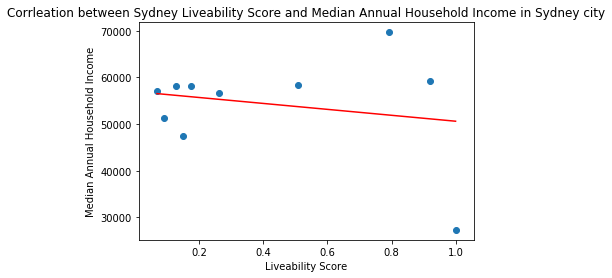

In [125]:
#correlation of median income and score
x = t_copy['Sydney liveability score']
y = t_copy['median_annual_household_income']
income = plt.scatter(x, y) 
income = plt.title('Corrleation between Sydney Liveability Score and Median Annual Household Income in Sydney city')
income = plt.xlabel('Liveability Score')
income = plt.ylabel('Median Annual Household Income')
#best fit line
income = plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='red')

In [126]:
corr = y.corr(x)
corr

-0.2098152290854435

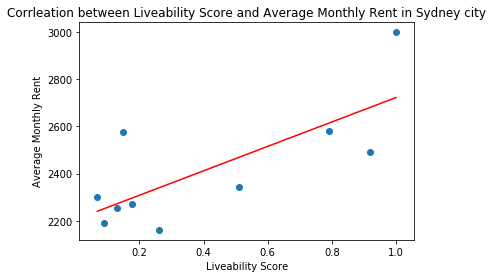

In [127]:
#correlation of average rent and score
x = t_copy['Sydney liveability score']
y = t_copy['avg_monthly_rent']
rent = plt.scatter(x, y) 
rent = plt.title('Corrleation between Liveability Score and Average Monthly Rent in Sydney city')
rent = plt.xlabel('Liveability Score')
rent = plt.ylabel('Average Monthly Rent')
#best fit line
rent = plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='red')

In [128]:
corr = y.corr(x)
corr

0.7470104164538529

In [129]:
conn.close()
db.dispose()